In [22]:
import numpy as np
import cv2
import PIL.Image as Image
import os
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.core import Dense,Flatten
from tensorflow.keras.models import Sequential


In [23]:
from tensorflow import keras
import PIL
import cv2
import matplotlib.pylab as plt
import numpy as np
from skimage.feature import greycomatrix, greycoprops
import pandas as pd
import pathlib


In [24]:
data_dir=r"C:\Users\COMPUTER CARE\OneDrive\Desktop\KIDNEY-DATASET\KIDNEY-DATASET\KIDNEY-DATASET"
data_dir = pathlib.Path(data_dir)
images_dict = {
    'Normal': list(data_dir.glob('normal/*')),
    'Cyst': list(data_dir.glob('cyst/*')),
    'Stone': list(data_dir.glob('stone/*')),
    'Tumor': list(data_dir.glob('tumor/*'))
    
}
labels_dict = {
    'Normal':0,
    'Cyst':1,
    'Stone':2,
    'Tumor':3
}

In [25]:
X, Y = [], []
for image_type, images in images_dict.items():
    
        
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224)) 
        X.append(resized_img)
        Y.append(labels_dict[image_type])

In [26]:
X=np.array(X)
Y=np.array(Y)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.2)

In [28]:



from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Flatten, Dense

# Load the ResNet152 model with pretrained weights
pretrained_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the pretrained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Create a new model using the ResNet152 backbone
resnet_model = tf.keras.models.Sequential()

# Add the ResNet152 backbone
resnet_model.add(pretrained_model)

# Add the classification head
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(4, activation='softmax'))

In [29]:
    resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 512)               51380736  
                                                                 
 dense_5 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 109,753,732
Trainable params: 51,382,788
Non-trainable params: 58,370,944
_________________________________________________________________


In [30]:
resnet_model.compile(
 optimizer="adam",
 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
 metrics=['accuracy'])
resnet_model.fit(X_train, y_train, epochs=3,steps_per_epoch=10)


Epoch 1/3
10/10 [==============================] - 864s 85s/step - loss: 101.7491 - accuracy: 0.4809
Epoch 2/3
10/10 [==============================] - 869s 87s/step - loss: 0.9704 - accuracy: 0.8472
Epoch 3/3
10/10 [==============================] - 852s 84s/step - loss: 0.1228 - accuracy: 0.9653


In [31]:
resnet_model.save('152.h5')

In [32]:
resnet_model = tf.keras.models.load_model('152.h5')
resnet_model.evaluate(X_test,y_test)

25/25 [==============================] - 1529s 63s/step - loss: 0.0191 - accuracy: 0.9925


[0.01905757747590542, 0.9925000071525574]

In [33]:
predictions=resnet_model.predict(X_test)

25/25 [==============================] - 230s 9s/step


In [34]:
predictions=np.array(predictions)
y_pred=[]
for i in predictions:
    i=list(i)
    y_pred.append(i.index(max(i[0],i[1],i[2],i[3])))
y_pred=np.array(y_pred)

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       192
           1       0.98      1.00      0.99       210
           2       0.99      0.97      0.98       194
           3       1.00      1.00      1.00       204

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



<Axes: >

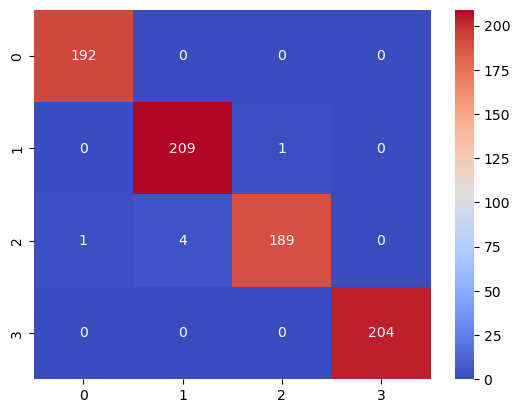

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline
cf_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(cf_matrix, annot=True,cmap='coolwarm',fmt='.3g')